In [ ]:
import os
import sys
import datetime
import pickle
from tqdm.notebook import tqdm
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')
# повышать качество вывода графики не стал, так как от этого тормозит (у меня) ноутбук

будет использоваться метрика R^2 как и в оригинальном задании

In [ ]:
np.random.seed(1)

In [ ]:
train_df = pd.read_csv('./flat_price/train.csv')
test_df = pd.read_csv('./flat_price/test.csv')

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
class Preprocessor:
    def __init__(self):
        self.medians = None
        self.means = None
        self.stds = None
        self.districts_healthcare = None
        self.current_year = datetime.datetime.now().year
        self.temp_df = None
        self.max_square_outlier = None
        self.min_square_outlier = None
        self.median_dictrict_price = None
        self.district_price = None
        self.kitchen_square_outlier = None
        self.median_distrcit_price = None
        self.scaler = RobustScaler(with_centering=False)
        self.scaler_cl = StandardScaler()
        self.pca = PCA(n_components=1, random_state=1)
        # значение n_clusters=3 получено с помощью метода локтя (параметр inertia_)
        self.kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
        self.district_square = None
        self.median_flat_price = None
        self.district_sq = None
    
    def fit(self, df):
        self.medians = df.median()
        self.means = df.mean()
        self.stds = df.std()
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        self.max_square_outlier = np.quantile(df['Square'], q=0.995)
        self.min_square_outlier = np.quantile(df['Square'], q=0.0015) # 0012
        self.kitchen_square_outlier = np.quantile(df['KitchenSquare'], q=0.995) # 9965
        self.temp_df = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})
        self.temp_df.columns = ['DistrictId', 'Rooms', 'MedPriceDistrict']
        self.median_dictrict_price = self.temp_df['MedPriceDistrict'].median()
        self.district_price = (df.groupby(['DistrictId'])['Price'].agg('median') \
                                                     / df.groupby(['DistrictId'])['Square'].agg('median')).to_dict()
        self.district_square = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()
        self.district_age = df.groupby(['DistrictId'])['HouseYear'].agg('median').astype(np.int16).to_dict()
        # self.bins = [0, 3, 6, 9, 12, 15, 18, df['Floor'].max()]
    
    def transform(self, df):        
        # устранение выбросов в годе постройки
        df.loc[df['HouseYear'] > self.current_year, 'HouseYear'] = self.medians.HouseYear
        
        # очень высокие и очень низкие значения площади (вместо random можно использовать медианы, но лучше не становится)
        df.loc[df['Square'] > np.quantile(df['Square'], q=0.999), 'Square'] = self.max_square_outlier
        sq_condition = (df['Square'] < self.min_square_outlier)
        df.loc[sq_condition, 'Square'] = np.random.uniform(low=self.min_square_outlier,
                                                           high=self.min_square_outlier + 3,
                                                           size=len(df[sq_condition]))
        square_condition = ((df['Square'] > 140) & (df['Rooms'] <= 3))
        df.loc[square_condition, 'Square'] = np.random.uniform(low=self.means.Square, 
                                                               high=self.means.Square + self.stds.Square,
                                                               size=len(df[square_condition]))
        
        # выбросы в площади кухни - очень высокие и странно низкие
        kitchen_condition = (df['KitchenSquare'] > self.kitchen_square_outlier)
        df.loc[kitchen_condition, 'KitchenSquare'] = \
                                      np.random.randint(low=self.means.KitchenSquare,
                                                        high=self.means.KitchenSquare + self.stds.KitchenSquare / 3.,
                                                        size=len(df[kitchen_condition]))
        median_kitchen_prop = self.medians.KitchenSquare / self.medians.Square
        df.loc[df['KitchenSquare'] < 5, 'KitchenSquare'] = median_kitchen_prop * \
                                                                df.loc[df['KitchenSquare'] < 5, 'Square'] + 1
        
        # заполнение пропусков в жилой площади - берем разность между общей площадью и площадью кухни минус подсобная площадь
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square'] * 0.1), inplace=True)
        
        # если жилая площадь больше разницы общей площади и кухни - вычисляем нормальную площадь
        # то же самое можно сделать для площади кухни, но такие аномалии не выявились
        lifesq_cond = (df['LifeSquare'] > np.abs(df['Square'] - df['KitchenSquare']))
        df.loc[lifesq_cond, 'LifeSquare'] = self.medians.LifeSquare / self.medians.Square * \
                                                    df.loc[lifesq_cond, 'Square']
        df.loc[lifesq_cond, 'KitchenSquare'] = df.loc[lifesq_cond, 'Square'] - df.loc[lifesq_cond, 'LifeSquare'] - 1
                
        # выбросы в жилой площади - слишком маленькая
        df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = np.abs(df.loc[df['LifeSquare'] < 10, 'Square'] * 0.9 - \
                                                                df.loc[df['LifeSquare'] < 10, 'KitchenSquare'])
        
        # заполнение выбросов в комнатах
        rooms_condition = ((df['Rooms'] > 6) | (df['Rooms'] == 0))
        room_median_square = self.medians.LifeSquare / self.medians.Rooms
        df.loc[rooms_condition, 'Rooms'] = np.round(df.loc[rooms_condition, 'LifeSquare'] / room_median_square)
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
         
        # на всякий случай, если где-то остались квартиры с общей площадью меньшей жилой, хотя не должно
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'], (df['LifeSquare'], df['Square']),\
                                                  (df['Square'], df['LifeSquare']))
        
        # пусть будет полседний этаж
        floor_condition = (df['Floor'] > df['HouseFloor'])
        df.loc[floor_condition, 'Floor'] = df.loc[floor_condition, 'HouseFloor']
        
        # заполнение пропусков в показателе здравоохранения
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)
        df['Healthcare_1'].clip(np.quantile(df['Healthcare_1'], q=0.97), axis=0, inplace=True)
        
        # количество человек на одну квартиру не должно превышать 10
        df.loc[df['Social_3'] > 10, 'Social_3'] = self.medians.Social_3
        
        # преобразование категориальных признаков, их можно (и скорее нужно) преобразовать через dummies, но получится слишком
        # много признаков, а эти особый вклад не вносят (на практике выигрыша в качестве не получилось)
        """
        df = pd.concat([df, pd.get_dummies(df[['Ecology_2', 'Ecology_3', 'Shops_2']])], axis=1)
        df = df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
        """
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # не имеет значения для модели
        df.drop('Id', axis=1, inplace=True)

        # оптимизация памяти
        df = reduce_mem_usage(df)
        
        # если образовались пропуски, которые мы не учли
        df.fillna(self.medians, inplace=True)
        
        return df
    
    def create_features(self, df):
        
        # медианная цена за n-комнатную квартиру в отдельном районе    
        df = df.merge(self.temp_df, on=['DistrictId', 'Rooms'], how='left')
        df['MedPriceDistrict'].fillna(self.median_dictrict_price, inplace=True)
        
        # цена за квадратный метр в районе
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price)
        
        # средняя площадь квартиры в районе
        df['DistrictSq'] = df['DistrictId'].map(self.district_square)
        
        # средний возраст района
        df['DistrictAge'] = df['DistrictId'].map(self.district_age)

        # категория этажа, чем выше (категория), тем дороже. Хотя сам Floor и отражает именно эту закономерность.
        # Что подтвердилось опытом
        # df['FloorClass'] = pd.cut(df['Floor'], bins=self.bins, labels=False)
        # df['FloorClass'].fillna(-1, inplace=True)
        
        # заполнить образовавшиеся пропуски
        if 'Price' in df.columns:
            self.median_flat_price = df['DistrictPrice'].median()
            self.district_sq = df['DistrictSq'].median()
            self.median_age = df['DistrictAge'].median()
        df['DistrictPrice'].fillna(self.median_flat_price, inplace=True)
        df['DistrictSq'].fillna(self.district_sq, inplace=True)
        df['DistrictAge'].fillna(self.median_age, inplace=True)
        
        # объединение социальных показателей в один признак и его масштабирование, т.к. по отдельности они не вносят особый вклад
        # добавление признаков на освнове кластеризации
        if 'Price' in df.columns:
            df['LifeStats'] = self.pca.fit_transform(self.scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3', 
                                                                                   'Shops_1', 'Healthcare_1',
                                                                                   'Ecology_1']]))
            # по логике нужно тогда избавиться от лишних признаков после их объединения в один, но качество модели снижается
            # df = df.drop(['Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Healthcare_1', 'Ecology_1'], axis=1)
            
            # добавление признаков на основе кластеров в данном случае спорно влияет на качество модели, можно и убрать
            df['Cluster'] = self.kmeans.fit_predict(self.scaler_cl.fit_transform(df.drop('Price', axis=1)))
    
        else:
            df['LifeStats'] = self.pca.transform(self.scaler.transform(df[['Social_1', 'Social_2', 'Social_3', 
                                                                           'Shops_1', 'Healthcare_1',
                                                                           'Ecology_1']]))
            
            # df = df.drop(['Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Healthcare_1', 'Ecology_1'], axis=1)

            df['Cluster'] = self.kmeans.predict(self.scaler_cl.transform(df))
                    
        df = pd.concat([df, pd.get_dummies(df['Cluster'])], axis=1)
        df.drop('Cluster', axis=1, inplace=True)
        df.rename(columns={0: 'Cluster_1', 1: 'Cluster_2', 2: 'Cluster_3'}, inplace=True)

        # удаляем DistrictId, к нему не применить one-hot encoding, а от увеличения/уменьшения его значений не зависит цена
        df.drop('DistrictId', axis=1, inplace=True)
            
        return df

In [ ]:
preprocessor = Preprocessor()
preprocessor.fit(train_df)

In [ ]:
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.52 MB
Decreased by 64.5%
Memory usage of dataframe is 0.69 MB
Memory usage after optimization is: 0.24 MB
Decreased by 65.3%


In [ ]:
train_df = preprocessor.create_features(train_df)
test_df = preprocessor.create_features(test_df)

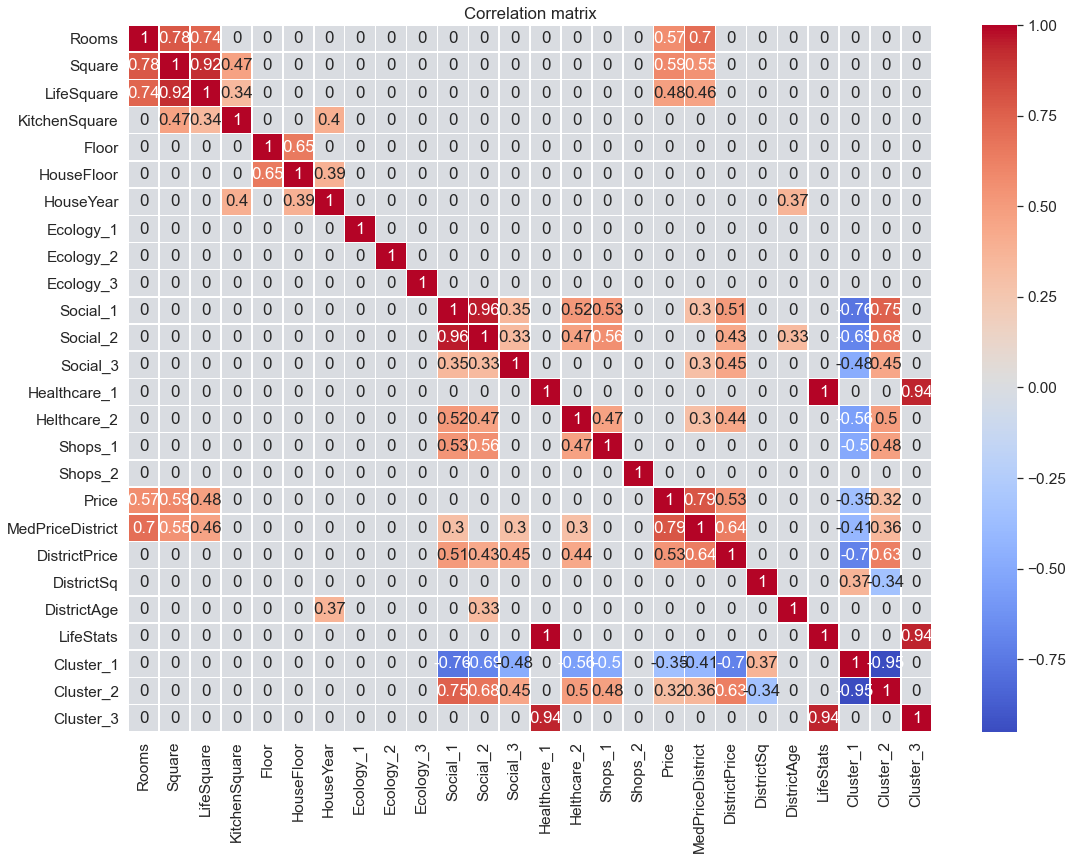

In [ ]:
# в большей степени для красоты картинки, на основве матрицы выбор осуществляться не будет
plt.figure(figsize = (18,13))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [ ]:
# функция для вывода оценки результатов работы обученной модели (из одного из уроков)
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "MSE_scaled:\t" + str(round(mse(true_values, pred_values) / np.median(true_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values, alpha=0.6)
    plt.plot([0, 635000], [0, 635000], linestyle='--', color='red')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    if save:
        if not os.path.exists('./saved'):
            os.makedirs('./saved')
        plt.savefig('./saved/' + 'report.png')
    plt.show()

In [ ]:
# если брать только признаки с максимальной корреляцией к целевой переменной, то результат становится значительно хуже, 
# но модель не переобучается
# однако, если брать весь набор, то R^2 увеличивается, но качество на test_df чуть ниже избранного набора 
# на raw наборе, разумеется, качество намного ниже
X, y = train_df.drop('Price', axis=1).values, train_df['Price'].values

In [ ]:
# класс, который выбирает наилучший поднабор признаков, исходя из заданной метрики
class ChooseBestSubset:
    def __init__(self, estimator, k_features, scoring='r2_score', test_size=0.25, random_state=1):
        self.scoring = str(scoring)
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if (self.scoring == 'r2_score') or (self.scoring == 'mse'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "r2_score" или "mse", дана: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                           random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_) # сначала для полного набора
        self.scores_ = [score]
        while dim > self.k_features: # цикл до тех пор, пока не будет наименее короткий заданный набор
            scores, subsets = [], []
            sys.stderr.write(f'Анализ наборов признаков {dim}/{X_train.shape[1]}, осталось {dim - self.k_features}:')
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim): # проверяем различные комбинации признаков 
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score) # записываем score текущего набора
                subsets.append(p) # записываем значения индексов текущего набора
            clear_output(wait=True)
            best = np.argmax(scores) if self.scoring == r2_score else np.argmin(scores) # находим лучший набор
            self.indices_ = subsets[best] # сохраняем значения индексов лучшего набора из текущей итерации while
            self.subsets_.append(self.indices_) # сохраняем лучший набор из текущей итерации while
            dim -= 1
            self.scores_.append(scores[best]) # сохраняем лучшее значение метрики на текущей итерации
        self.k_score_ = self.scores_[-1] # scores для последнего набора = k_features
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, indices): # вычисляем метрику набора
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
# ячейка, ожидаемо, выполняется очень долго - нужно перебрать много моделей
boost_test = GradientBoostingRegressor(max_depth=3, random_state=1, n_estimators=150)
selector = ChooseBestSubset(boost_test, k_features=12, test_size=0.15)
selector.fit(X, y)

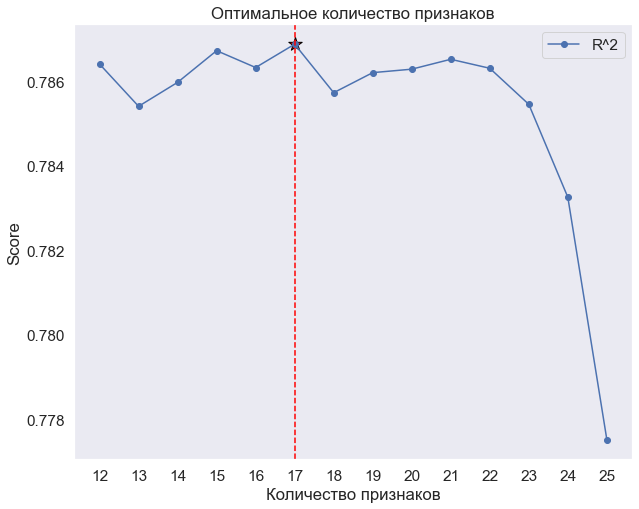

In [ ]:
k_feat = [len(k) for k in selector.subsets_] # вычисляем длины наборов
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='R^2')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Оптимальное количество признаков')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.legend(loc='best')
plt.xticks(k_feat)
plt.grid(color='orange', alpha=0.3) # из-за вывода матрицы корреляции с заданным стилем уходит сетка
plt.show()

In [ ]:
selector.subsets_[np.argmax(np.array(selector.scores_))] # номера столбцов для избранного набора

(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 20, 23)

In [ ]:
columns = train_df.columns[train_df.columns != 'Price']
cols = [columns[i] for i in selector.subsets_[np.argmax(np.array(selector.scores_))]]
cols += ['Price']
df_selected_cbs = train_df[[*cols]]
df_selected_cbs.head(1)

,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Shops_1,Shops_2,MedPriceDistrict,DistrictPrice,DistrictAge,Cluster_2,Price
0,3.0,115.027313,93.524582,4.0,10.0,2014.0,0.075424,1,1,11,3097,0,1,213530.788443,2669.535159,1977,0,305018.875


In [ ]:
df_selected_cbs.shape

(10000, 18)

In [ ]:
X, y = df_selected_cbs.drop('Price', axis=1).values, df_selected_cbs['Price'].values
# далеко не вседа выбранный таким методом набор данных дает наилучшее значение метрики R^2
# но, возможно, это каким-то образом устарнит проклятие размерности, если таковое имеется

<h3>Выбор модели</h3>

In [ ]:
def cross_score(X, y, clf, num_splits=5, scoring=None):
    scores = cross_val_score(estimator=clf, X=X, y=y, scoring=scoring, cv=num_splits, n_jobs=-1)
    print(f'Accuracy on cross_validation: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

In [ ]:
# попробуем свою линейную регрессию 
class CustomLinearRegression(BaseEstimator, TransformerMixin):
    def __init__(self, eta=0.001, epochs=20, l2=0., seed=None, patience=15, min_delta=0.0,
                 eta_factor=0.1, eta_patience=15, eta_min_delta=0.0, min_eta=1e-8):
        self.eta = eta # скорость обучения
        self.epochs = epochs # количество эпох обучения
        self.random = np.random.RandomState(seed) # воспроизводимость
        self.min_loss = np.inf
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.counter_eta = 0
        self.l2 = l2 # коэффициент регуляризации
        self.eta_factor = eta_factor
        self.eta_patience = eta_patience
        self.eta_min_delta = eta_min_delta
        self.min_eta = min_eta
        self.best_weights = None
        assert self.min_eta < self.eta, 'Set learning rate higher than min_learning_rate.'
    def fit(self, X, y):
        self.weights = self.random.normal(loc=0.0, scale=0.01, # инициализируем веса близкими к 0
                                      size=(1 + X.shape[1]))
        self.losses = []
        for _ in range(self.epochs):
            output = self.input_(X) # выисляем выход сети 
            errors = (output - y) # вычисляем ошибку
            grad = (X.T.dot(errors) + self.l2 * self.weights[1:]) # вычисляем градиент + регуляризация / *2/y.shape[0] = 1
            self.weights[1:] -= self.eta * grad # обновляем веса умножаем на скорость обучения
            self.weights[0] -= self.eta * errors.sum() # bias не регуляризируется
            l2_term = self.l2 * np.sum(self.weights[1:]**2) # параметр L2 для целевой функции
            loss = (errors**2).sum() / 2.0 + l2_term # вычисление среднекв-ой ошибки (которую мы стремимся миниминзировать)
            self.losses.append(loss) # собираем значения потерь, чтобы их потом визуализировать
            if loss - self.min_loss < self.min_delta:
                self.min_loss = loss
                self.best_weights = self.weights.copy()
                self.counter = 0
            else:
                self.counter += 1
            if self.counter == patience:
                self.weights = self.best_weights
                print(f'Loss did not improve for {self.patience} epochs. Training stopped.')
                break
            if loss - self.min_loss < self.eta_min_delta:
                self.counter_eta = 0
            else:
                self.counter_eta += 1
            if self.counter_eta == self.eta_patience:
                self.eta *= self.eta_factor
            if self.eta == self.min_eta:
                self.weights = self.best_weights
                print(f'Learning rate is equal to min_learning rate: {self.eta}, training stopped')
                break
        return self
    def input_(self, X): # x1 * w1 + x2 * w2 + ... + b
        return np.dot(X, self.weights[1:]) + self.weights[0]
    def predict(self, X): # вычисление вывода - линейная активация
        return self.input_(X)

R2:	0.704
RMSE:	50678.38
MSE:	2568298185.646
MSE_scaled:	13357.793


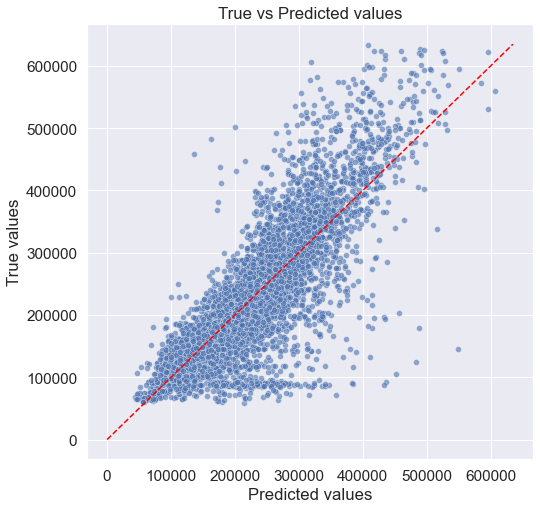

R2:	0.732
RMSE:	46976.427
MSE:	2206784692.426
MSE_scaled:	11479.999


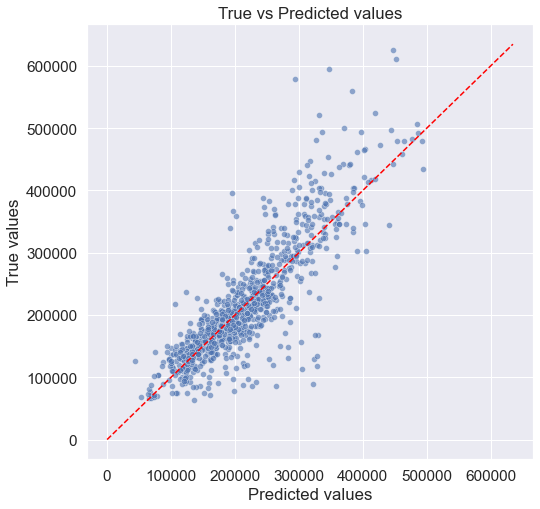

In [ ]:
sc_x, sc_y = StandardScaler(), StandardScaler()
split_ = int(0.9 * X.shape[0])
indices = np.arange(X.shape[0])
# с shuffle правильнее, но страдает воспроизводимость результата, а нам всего лишь надо оценить возможности набора на базовой модели
#np.random.shuffle(indices)
train_ind, test_ind = indices[:split_], indices[split_:]
X_train, X_test = X[train_ind, :], X[test_ind, :]
y_train, y_test = y[train_ind], y[test_ind]
X_train_std, y_train_std = sc_x.fit_transform(X_train), sc_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
X_test_std, y_test_std = sc_x.transform(X_test), sc_y.transform(y_test.reshape(-1, 1)).reshape(-1)
lr = CustomLinearRegression(seed=1, epochs=70, eta=0.00001, l2=0.1) 
lr.fit(X_train_std, y_train)
y_train_pred = lr.predict(X_train_std)
y_test_pred = lr.predict(X_test_std)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred, save=True)

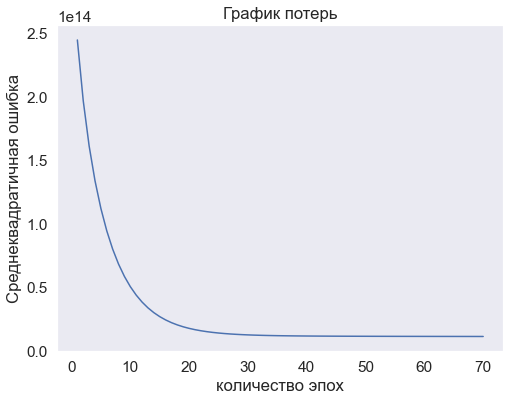

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, lr.epochs + 1), lr.losses)
plt.ylabel('Среднеквадратичная ошибка')
plt.xlabel('количество эпох')
plt.title('График потерь')
plt.grid(alpha=0.3, color='orange')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=1)

In [ ]:
# если вдруг пригодится
sc_x, sc_y = StandardScaler(), StandardScaler()
X_train_std, y_train_std = sc_x.fit_transform(X_train), sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
X_test_std, y_test_std = sc_x.transform(X_test), sc_y.transform(y_test[:, np.newaxis]).flatten()

<b>GradientBoostingRegressor</b>

R2:	0.815
RMSE:	39660.087
MSE:	1572922474.737
MSE_scaled:	8190.655


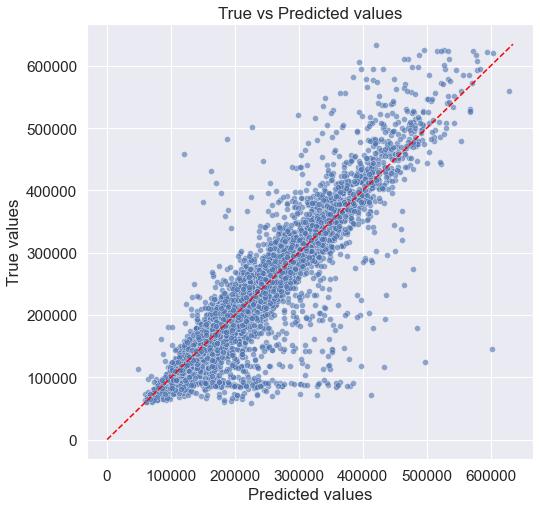

R2:	0.799
RMSE:	43379.52
MSE:	1881782715.592
MSE_scaled:	9750.651


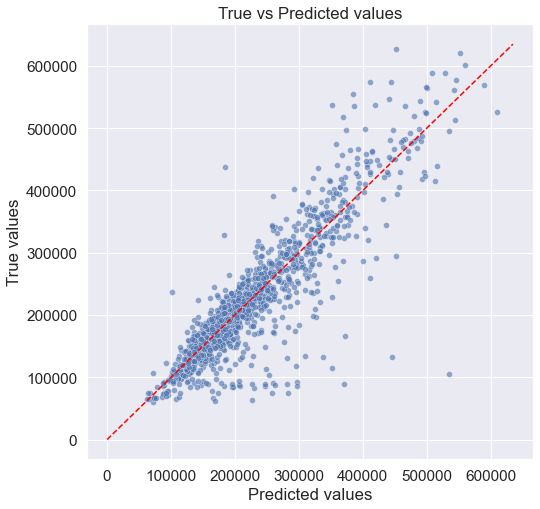

In [ ]:
boost = GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=60, 
                                  random_state=1, n_estimators=1050, tol=1e-2, warm_start=True,
                                  max_features='sqrt', loss='huber', learning_rate=0.02,
                                  init=make_pipeline(RobustScaler(), LinearRegression())) 
# RobustScaler более чувствителен к наличию выбросов (как я понял)
boost.fit(X_train, y_train)
y_train_pred = boost.predict(X_train)
y_test_pred = boost.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
# самая точная модель. StackingRegressor не дал таких результатов, видимо, в связи с тем, что у меня нет особо точных моделей
# для параметра estimators
# тот же блокнот, запущенный в Google Colab дает на несколько сотых лучшую R^2 и чуть более низкие MSE \_:/_/
# графики довольно грязные
# пока не удалось догадаться как устранить (учитывая, что сами значения признаков в наборе адекватные) хвост, где y_true
# между 90000 и 100000, а предсказанные значения растянулись от 100000 до почти 400000
# есть предположение, что это происходит из-за того, что квартир с такими площадями и ценой в этом диапазоне намного меньше,
# чем квартир с такими площадями и более высокими ценами, поэтому модель обучается больше на более дорогих и для более дешевых
# дает ложный результат. В конце попробуем разбить набор по MedPriceDistrict (имеет наибольшую корреляцию с целевой 
# переменной) и обучить эти поднаборы на отдельных моделях

In [ ]:
cross_score(X_train, y_train, boost)
# модель переобучена, вероятно, при неудачном наборе новых данных будет низкий результат

Accuracy on cross_validation: 0.762 +/- 0.027


array([0.75722853, 0.73701527, 0.79980916, 0.78552669, 0.73062992])

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
mlp = make_pipeline(RobustScaler(), MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam',
                                                alpha=0.0001, batch_size=32, learning_rate='adaptive', 
                                                learning_rate_init=0.001, max_iter=200, shuffle=True,
                                                random_state=1, tol=1e-4, warm_start=True, early_stopping=True,
                                                validation_fraction=0.1, n_iter_no_change=15))

In [ ]:
mlp.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpregressor',
                 MLPRegressor(batch_size=32, early_stopping=True,
                              hidden_layer_sizes=(100, 100),
                              learning_rate='adaptive', n_iter_no_change=15,
                              random_state=1, warm_start=True))])

R2:	0.717
RMSE:	48996.685
MSE:	2400675100.515
MSE_scaled:	12500.999


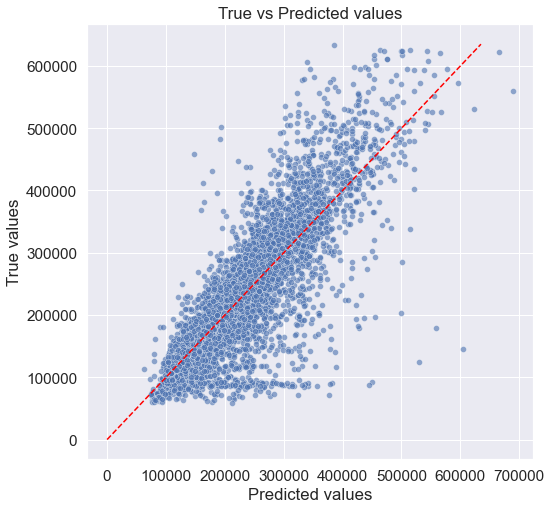

R2:	0.749
RMSE:	48484.395
MSE:	2350736579.85
MSE_scaled:	12180.584


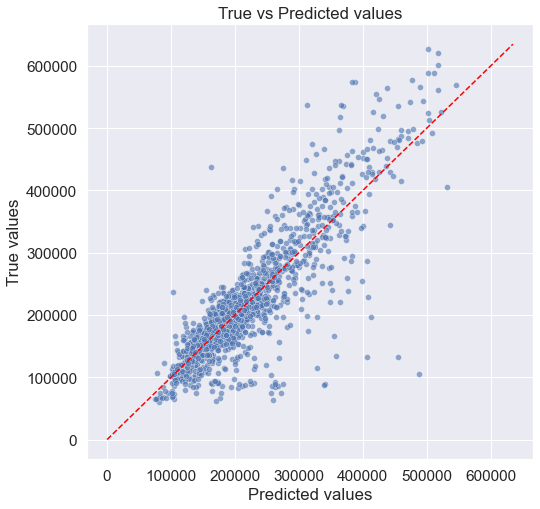

In [ ]:
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)
evaluate_preds(y_train, y_train_pred_mlp)
evaluate_preds(y_test, y_test_pred_mlp)

In [ ]:
cross_score(X_train, y_train, mlp)

Accuracy on cross_validation: 0.712 +/- 0.024


array([0.72350047, 0.69548611, 0.7396145 , 0.72625073, 0.67375511])

1) HouseYear	0.15443488289988702
2) Square	0.15163407551026387
3) DistrictPrice	0.10988439922394205
4) MedPriceDistrict	0.09506784135935441
5) LifeSquare	0.08668346926579473
6) HouseFloor	0.08060202867716755
7) Social_2	0.06172892985653337
8) Ecology_1	0.05547648049917515
9) Social_1	0.050539895509874984
10) DistrictAge	0.04920937745672401
11) Floor	0.03968503113903436
12) Shops_1	0.028424157999774966
13) Rooms	0.022685539105788043
14) Cluster_2	0.010875633141806012
15) Shops_2	0.001991058597766109
16) Ecology_3	0.0010771997571134108
17) Ecology_2	0.0


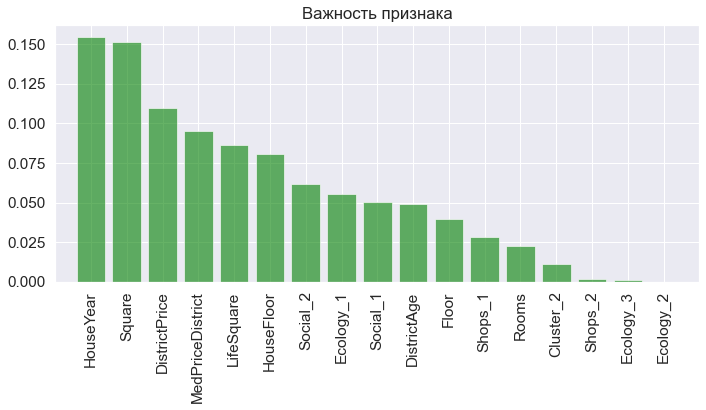

In [ ]:
feat_labels = np.array(df_selected_cbs.drop('Price', axis=1).columns)
#feat_labels = np.array(train_df.drop('Price', axis=1).columns)
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]
for x in range(X.shape[1]):
    print(f'{x+1}) {feat_labels[indices[x]]}\t{importances[indices[x]]}')
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X.shape[1]), importances[indices], align='center', alpha=0.6, color='green')
plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()
# важность признаков перераспределилась по отношению к real_estate_pricing.ipynb так как в качестве параметра init использовалась 
# LinearRegression()

In [ ]:
# predict test_df, predict train values
df_res = pd.DataFrame([boost.predict(X_test), y_test]).transpose()
df_res.columns = ['predicted', 'true']
df_res['diff'] = df_res['true'] / df_res['predicted'] * 100 - 100
len(df_res[np.abs(df_res['diff']) > 50]) # много безумных результатов, что и по графику очевидно

40

In [ ]:
test_pred = boost.predict(test_df[[*cols[:-1]]])
#test_pred = boost.predict(test_df)

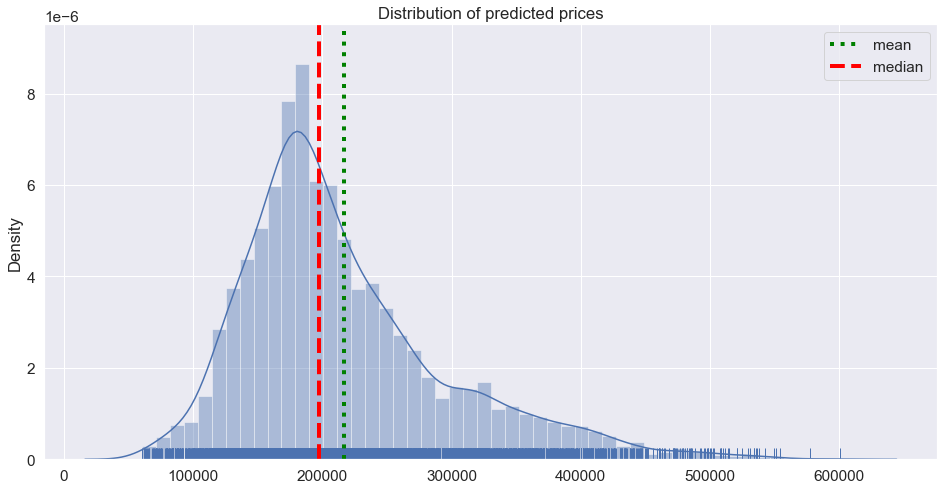

In [ ]:
df_pred = pd.DataFrame({'predicted':test_pred})
target_mean = round(df_pred['predicted'].mean(), 2)
target_median = df_pred['predicted'].median()

plt.figure(figsize = (16, 8))

sns.distplot(df_pred, bins=50, rug=True)

plt.axvline(target_mean, label='mean', linestyle=':', color='green', linewidth=4)
plt.axvline(target_median, label='median', linestyle='--', color='red', linewidth=4)

plt.title('Distribution of predicted prices')
plt.legend()
plt.show()
# распределение предсказанной цены несколько отличается от изображения true цены

In [ ]:
with open('model.pkl', 'wb') as infile:
    pickle.dump(boost, infile)

In [ ]:
sub_df = pd.read_csv('./flat_price/test.csv')
Submission = pd.concat([sub_df['Id'], df_pred['predicted']], axis=1)
Submission.rename(columns={'predicted': 'Price'}, inplace=True)

In [ ]:
Submission.to_csv('Submission.csv', index=False)

In [ ]:
Submission.head(10)

,Id,Price
0,4567,170193.885353
1,5925,122561.656957
2,960,141348.956369
3,3848,94687.353603
4,746,180369.351615
5,868,390910.432811
6,672,120373.073956
7,2471,218856.299832
8,4510,112346.924179
9,8354,211193.821673


результат на Kaggle - 0.73583 (и то на кривом варианте Preprocessor), что, безусловно, вгоняет в тоску. Причина (на мой взгляд) - слабая (очень много генерации данных, в т.ч. с применением необдуманных границ для outliers) предобработка данных. Как и говорила преподаватель (Александра Гордей): при неплохих значениях R^2 модель делает посредственные предсказания. Вообще, состав набора получился странным :) как вывод: лучшая модель GradientBosstingRegressor (boost).

In [ ]:
# жест отчаяния (здесь нет вывода, т.к. работа с keras велась в colab, на моем ПК tensorflow не устанавливается - старое железо)
from tensorflow import keras

In [ ]:
# модель, состоящая из нескольких полносвязных слоев (многослойный персептрон)
model = keras.Sequential([
                keras.layers.Dense(512, activation='relu', input_shape=(X_train_std.shape[-1], )),
                keras.layers.Dense(512, activation='relu'),
                keras.layers.Dropout(0.5), # "ансамблевая" регуляризация 
                keras.layers.Dense(256, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(256, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1) # без активации / output = logits - как раз для регрессии
])
model.summary()

In [ ]:
# создание модели, выбор метрик и обучение с остановкой при отсутствии прогресса в метрике
metrics = [
           keras.metrics.MSE,
]
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='Huber', metrics=metrics) 
callbacks = [keras.callbacks.ModelCheckpoint('model_epoch_{epoch}.h5'),
             #keras.callbacks.ReduceLROnPlateau(), # лучше динамически не понижать скорость обучения
             keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15),
             ]

history = model.fit(X_train_std, y_train, batch_size=64, epochs=400, verbose=2, callbacks=callbacks,
          validation_data=(X_test_std, y_test))

In [ ]:
y_train_pred_keras = model.predict(X_train_std)
y_test_pred_keras = model.predict(X_test_std)

In [ ]:
r2_score(y_train, y_train_pred_keras), r2_score(y_test, y_test_pred_keras)
# (0.7226341904825919, 0.7626917493312142) без DistrictAge

In [ ]:
y_sub = model.predict(sc_x.transform(test_df[[*cols[:-1]]]))

результат примерно такой же как и с sklearn

Попробуем разбить наш набор на 4 части, основываясь на значениях квантилей и обучим отдельные модели
Применим их к тестовому набору (спойлер - качество предсказания увелилчлось с 0.72930 до 0.73978 на Kaggle, в Colab - там вообще все точнее получается - так не может быть, но факт)

In [ ]:
condition1 = np.quantile(train_df['MedPriceDistrict'], q=0.25)
condition2 = np.quantile(train_df['MedPriceDistrict'], q=0.5)
condition3 = np.quantile(train_df['MedPriceDistrict'], q=0.75)
df1 = df_selected_cbs.loc[df_selected_cbs['MedPriceDistrict'] < condition1, df_selected_cbs.columns]
df2 = df_selected_cbs.loc[(df_selected_cbs['MedPriceDistrict'].between(condition1, condition2)), df_selected_cbs.columns]
df3 = df_selected_cbs.loc[df_selected_cbs['MedPriceDistrict'].between(condition2, condition3), df_selected_cbs.columns]
df4 = df_selected_cbs.loc[df_selected_cbs['MedPriceDistrict'] > condition3, df_selected_cbs.columns]
df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0] # чуть больше, чем образцов всего, но это не страшно в общем

(2463, 2586, 2513, 2497)

In [ ]:
X1, y1 = df1.drop('Price', axis=1), df1['Price']
X2, y2 = df2.drop('Price', axis=1), df2['Price']
X3, y3 = df3.drop('Price', axis=1), df3['Price']
X4, y4 = df4.drop('Price', axis=1), df4['Price']

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15, shuffle=True, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.15, shuffle=True, random_state=1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.15, shuffle=True, random_state=1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.15, shuffle=True, random_state=1)

In [ ]:
boost1 = GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=60, 
                                  random_state=1, n_estimators=1050, tol=1e-2, warm_start=True,
                                  max_features='sqrt', loss='huber', learning_rate=0.02,
                                  init=make_pipeline(RobustScaler(), LinearRegression())) 
boost1.fit(X1_train, y1_train)
y1_train_pred = boost1.predict(X1_train)
y1_test_pred = boost1.predict(X1_test)

In [ ]:
boost2 = GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=60, 
                                  random_state=1, n_estimators=650, tol=1e-2, warm_start=True,
                                  max_features='sqrt', loss='huber', learning_rate=0.02,
                                  init=make_pipeline(RobustScaler(), LinearRegression())) 
boost2.fit(X2_train, y2_train)
y2_train_pred = boost2.predict(X2_train)
y2_test_pred = boost2.predict(X2_test)

In [ ]:
boost3 = GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=60, 
                                  random_state=1, n_estimators=1050, tol=1e-2, warm_start=True,
                                  max_features='sqrt', loss='huber', learning_rate=0.02,
                                  init=make_pipeline(RobustScaler(), LinearRegression())) 
boost3.fit(X3_train, y3_train)
y3_train_pred = boost3.predict(X3_train)
y3_test_pred = boost3.predict(X3_test)

In [ ]:
boost4 = GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=60, 
                                  random_state=1, n_estimators=1050, tol=1e-2, warm_start=True,
                                  max_features='sqrt', loss='huber', learning_rate=0.02,
                                  init=make_pipeline(RobustScaler(), LinearRegression())) 
boost4.fit(X4_train, y4_train)
y4_train_pred = boost4.predict(X4_train)
y4_test_pred = boost4.predict(X4_test)

In [ ]:
y_train_join = np.hstack([y1_train, y2_train, y3_train, y4_train])
y_train_pred_join = np.hstack([y1_train_pred, y2_train_pred, y3_train_pred, y4_train_pred])
r2_score(y_train_join, y_train_pred_join)

0.8348534856211735

In [ ]:
y_test_join = np.hstack([y1_test, y2_test, y3_test, y4_test])
y_test_pred_join = np.hstack([y1_test_pred, y2_test_pred, y3_test_pred, y4_test_pred])
r2_score(y_test_join, y_test_pred_join)

0.794767492714043

In [ ]:
cols.remove('Price')
test_df_sel = test_df[[*cols]]

In [ ]:
condition1 = np.quantile(test_df['MedPriceDistrict'], q=0.25)
condition2 = np.quantile(test_df['MedPriceDistrict'], q=0.5)
condition3 = np.quantile(test_df['MedPriceDistrict'], q=0.75)
test_df_sel.loc[test_df_sel['MedPriceDistrict'] < condition1, 'Price'] = boost1.predict(test_df_sel.loc[test_df_sel['MedPriceDistrict'] < condition1, cols])
test_df_sel.loc[(test_df_sel['MedPriceDistrict'].between(condition1, condition2)), 'Price'] = boost2.predict(test_df_sel.loc[test_df_sel['MedPriceDistrict'].between(condition1, condition2), cols])
test_df_sel.loc[(test_df_sel['MedPriceDistrict'].between(condition2, condition3)), 'Price'] = boost3.predict(test_df_sel.loc[test_df_sel['MedPriceDistrict'].between(condition2, condition3), cols])
test_df_sel.loc[test_df_sel['MedPriceDistrict'] > condition3, 'Price'] = boost4.predict(test_df_sel.loc[test_df_sel['MedPriceDistrict'] > condition3, cols])

In [ ]:
sub_df = pd.read_csv('./flat_price/test.csv')
Submission = pd.concat([sub_df['Id'], test_df_sel['Price']], axis=1)
Submission.to_csv('Submission.csv', index=False)

In [ ]:
# далее можно продолжать оптимизировать параметры отдельных моделей либо вовсе пробовать иные модели на небольших уже наборах данных

Очень здорово, что предобработка данных оформлена в виде sklearn-овского API. На самом деле, для такого уже есть класс :) Называется pipeline, по сути это массив из классов, имеющих методы fit, transform, predict. Хорош тем, что исключает возможность утечки данных тестовой выборки в обучающую. Подробнее в документации: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
Ну и в этом случае каждый собственноручно написанный этап предобработки оформляется в отдельный класс (в разумных границах; не по классу на каждую строчку кода :) ).

По -русски метод локтя называется методом колен.

По поводу самой предобработки: супер, отличное порождение новых признаков и работа с выбросами.
Насчет рандома: при работе с данными люди стараются минимизировать ошибки и шум, а рандом может его прибавить. Если используете его, смотрите, из какого распределения данные (равномерное, нормальное, или другое) и создавайте экземпляры из этого распределения с такими же характеристиками (центр и разброс для нормального распределения, диапазон для равномерного). Эта техника ("придумывание" объектов рандомом из реального распределения) называется сэмплированием.

Из матрицы корреляций вы видите, что у вас есть практически одинаковые признаки. Линейные модели это ломает, а для остальных просто не имеет смысла для обучения. Признаки с корреляцией 0.96 можно считать одним признаком.

Все действия с данными четко прокомментированы. Интересно, пробовали ли вы обучать модели без РСА? Сильный ли выигрыш?

Тоже люблю tqdm, красивый :)
Прямой перебор, как вы заметили, ну очень долгий, в реальных ситуациях на такое обычно нет ресурсов. Можно использовать для подбора признаков какие-то математические и общие соображения (выкинуть высоко коррелирующие между собой и низко коррелириующие с таргетом). Кроме того, можно подобучить сильные нелинейные алгоритмы (например, случайный лес или бустинг) и посмотреть на значимость фич. Подобучить, потому что это еще не этап построения модели, т.е. мы не обязательно хотим использовать случайный лес как модель, мы хотим оценить с его помощью значимость признаков, поэтому обучим не на всем X_train, а на его небольшой части, ~30-30% будет норм. Ну и надо помнить, что это делается для прикидки и экономии ресурсов, результат дает менее надежный, чем перебор в лоб.

График с R^2 от количества признаков очень симпатичный.
Про проклятье размерностей верно, правда, его лучше устранять методами, не подверженными проклятью размерностей :) Иначе выгода в ресурсах под вопросом. Перебор к таким не относится. Вообще обратите внимание на предварительный отбор фич, не в ходе обучение и экперимента, хотя это тоже важно и нужно, а еще перед ним, на этапе разведки данных. Это гистограммы, корреляции и другие визуализирующие датасет забавы. :)
В общем, эксперимент с перебором признаков хороший, но как реальная практика, пожалуй, слишком дорогой.

Классно, что написана своя линейная регрессия. В реальной работе не вижу в этом смысла, потому что все модели в библиотеках отлично оптимизированы, а в качестве упражнения супер, прописывать модели самостоятельно - идеальный рецепт их глубоко понимания.
Вы хорошо инициализируете веса, но я не могу предугадать, насколько это сознательно, поэтому на всякий случай оставлю хорошее обсуждение на эту тему: https://datascience.stackexchange.com/questions/30989/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero
Там есть замечание о том, что в случае единственного минимума у функции ошибки (а поиск минимума этой функции и есть мат. постановка задачи обучения модели), он будет найден. Это правда, но в зависимости от инициализации начальных параметров моделей он ищется за разное время. Если все веса регрессии равны одному числу, это время потенциально увеличивается.

10% на тестовую выборку маловато, обычно берут 20-40%.
Бустинг n_estimators=1050 почти железно переобучен, несмотря на ограничение по глубине и ширине деревьев. Слишком уж их много, вплоть до того, что каждое дерево может обучиться на 2-5 конкретных объектов.
Кроме того, в качестве модели для первого предсказания используется линейная регрессия. Использовать какие бы то ни было линейные модели на мультиколлинеарных данных некорректно, не верьте этим результатам :) Мультиколлинеарность - линейная зависимость между признаками, её видно из высокого коэффициента корреляции между ними. В вебинаре про обучение с учителем это разобрано, можно освежить в памяти. То же относится к последующему блоку с выбором модели.

Горизонтальный хвост интересный, вашу гипотезу можно проверить,

"Жест отчаяния" позабавил :)
По поводу расхождения на kaggle и colab: удивительная загадка, что-то похожее описано тут: https://stackoverflow.com/questions/66529577/wild-discrepancies-between-training-deeplab-resnet-v3-on-google-colab-versus-on/66544133#66544133
Ещё из дурацкого: может быть такое, что в колабе по умолчанию задана меньшая точность для хранения float, чем в кагле. Это можно проверить, посмотрев тип данных предсказания.

Идея обучать отдельно по квантилям прикольная, но с оглядкой на общее количество данных. Замечание про бесконечное улучшение параметров моделей и ансамблирование - абсолютная правда, так и выигрываются кагловские соревнования :)

Во вспомогательном ноутбуке график Desition Tree вполне естественный, если подумать, как обучается эта модель. Она каждый раз выбирает признак и порог А, далее объекты, где значение признака меньше А, собирает в одну подвыборку, а где больше - в другую. Для этих подвыборок выбирается новый признак, новый порог и все повторяется. При обучении оптимизируется выбор признака и порога. Ну и понятно, что в итоге модель "запомнит" конечное количество разделений, график это и отражает.
Картинки и разведка данных супер, красиво и наглядно.

Вы проделали большую кропотливую работу, надеюсь, было интересно! Библиотеки уж точно усвоены, проект отличный!
Успехов в дальнейших трудах!